Block_net.jpg


This tutorial outlines the script for the Recurrent Spiking Neural Network (RSNN) as implemented in the manuscript. It's important to note that this code draws inspiration from the work done at https://github.com/surrogate-gradient-learning.

We'll utilize the NNI toolkit (https://github.com/microsoft/nni) for grid search and hyperparameter optimization.

Downlaod the NNI library

In [1]:
! pip install nni

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: filelock
    Found existing installation: filelock 3.13.4
    Uninstalling filelock-3.13.4:
      Successfully uninstalled filelock-3.13.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu

Install all the required libraries

In [2]:
import pickle
import pandas as pd
import numpy as np
import h5py
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plot
from torch.utils.data import TensorDataset, DataLoader
import nni
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**The dataset will be published soon**. It comprises the encoding of 8 artificial gratings, as described in the encoding tutorial. We will use the encoding method employing a refractory period combination of 1&1 (1 ms for SA-I and RA-I). The dataset collected with a sliding velocity of 8.6 mm/s and an indentation force of 12 N is used here.

In [3]:
!unzip /content/data_npy.zip -d /content

Archive:  /content/data_npy.zip
   creating: /content/data_npy/Texture_1/
  inflating: /content/data_npy/Texture_1/data_0.npy  
  inflating: /content/data_npy/Texture_1/data_1.npy  
  inflating: /content/data_npy/Texture_1/data_10.npy  
  inflating: /content/data_npy/Texture_1/data_100.npy  
  inflating: /content/data_npy/Texture_1/data_101.npy  
  inflating: /content/data_npy/Texture_1/data_102.npy  
  inflating: /content/data_npy/Texture_1/data_103.npy  
  inflating: /content/data_npy/Texture_1/data_104.npy  
  inflating: /content/data_npy/Texture_1/data_105.npy  
  inflating: /content/data_npy/Texture_1/data_106.npy  
  inflating: /content/data_npy/Texture_1/data_107.npy  
  inflating: /content/data_npy/Texture_1/data_108.npy  
  inflating: /content/data_npy/Texture_1/data_109.npy  
  inflating: /content/data_npy/Texture_1/data_11.npy  
  inflating: /content/data_npy/Texture_1/data_12.npy  
  inflating: /content/data_npy/Texture_1/data_13.npy  
  inflating: /content/data_npy/Texture

This step defines the values of the hyperparameter to get started with as a first trail in the grid search. All the tested values can be found in the "GridSearch" script

In [4]:
params = {
          'Hidden_size': 30,
          'batch_size':64,
          'fwd_weight_scale': 0.8,
          'rec_weight_scale':10e-3,
          'scale': 5,
          'tau_mem':10e-3,
          'tau_syn':20e-3,
          }
optimized_params = nni.get_next_parameter()
params.update(optimized_params)

/usr/local/lib/python3.10/dist-packages/nni/runtime/trial_command_channel/standalone.py:34: RuntimeWarning: Running trial code without runtime. Please check the tutorial if you are new to NNI: https://nni.readthedocs.io/en/stable/tutorials/hpo_quickstart_pytorch/main.html
  warnings.warn(warning_message, RuntimeWarning)


Prepare the dataset in a data frame. For the sake of simplicuty, we use 220 trails for each grating. Each trails consits of 500 ms (500 * 2k/second = 1000 time stamp) of sliding duration.

In [5]:
data_path = '/content/data_npy'
path2save = '/content/Models'
all_files = glob.glob(data_path+ '/*/*')
li = []
for i in all_files:
    df = np.load(i)
    li.append(df)

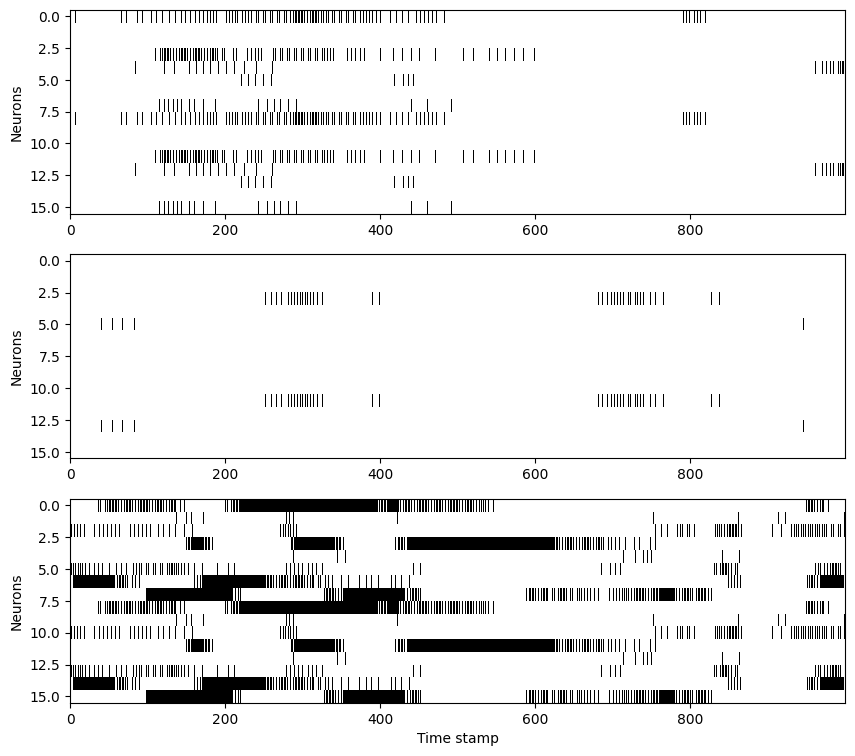

In [6]:
plt.figure(figsize=(10, 9))
plt.subplot(311)
plt.imshow(li[100].T, aspect='auto', cmap='binary', interpolation='none')###Grating 8
plt.ylabel('Neurons')
plt.subplot(312)
plt.imshow(li[1100].T, aspect='auto', cmap='binary', interpolation='none')###Grating 5
plt.ylabel('Neurons')
plt.subplot(313)
plt.imshow(li[1720].T, aspect='auto', cmap='binary', interpolation='none')###Grating 1
plt.ylabel('Neurons')
plt.xlabel('Time stamp')
plt.show()

In [7]:
dtype = torch.float
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
Grating_Lbl = np.arange(0,8)
nb_repetitions = 220 ### 220 trails per each grating

In [9]:
data = []
labels = []
for i, letter in enumerate(Grating_Lbl):
    for repetition in np.arange(nb_repetitions):
        idx = i * nb_repetitions + repetition
        labels.append(i)

data_steps = l = np.min([len(d) for d in li]) ### Ensure all the trails of all gratings have the same number of time stamps.
data = torch.tensor([d[:l] for d in li], dtype=dtype) #### convert each trail into a tensor

<ipython-input-9-4f995b71a778>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  data = torch.tensor([d[:l] for d in li], dtype=dtype) #### convert each trail into a tensor


In [10]:
###We will use the "reshape" function to reshape the tensor into (1,number of inputs, time stamps)
def reshape(data, n=2):
    shp = data.shape
    tmp = data.reshape(shp + (1,))
    tmp = data.tile((1, 1, 1, n))
    return tmp.reshape((shp[0], n * shp[1], shp[2]))

In [11]:
data = reshape(data, n= 1)

In [12]:
idx = np.arange(len(data))
np.random.shuffle(idx)
data = np.asarray(data)[idx]
labels = np.array(labels)[idx]

Split the dataset into (80/10/10)% for training, testing and validation.

In [13]:
a = int(0.8* len(idx))
x_train, x_test = data[:a], data[a:]
y_train, y_test = labels[:a], labels[a:]
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train = torch.tensor(x_train, device=device, dtype=dtype)
x_test = torch.tensor(x_test, device=device, dtype=dtype)
x_val = torch.tensor(x_val, device = device, dtype=dtype)
y_train = torch.tensor(y_train, device=device, dtype=dtype)
y_train = y_train.type(torch.LongTensor)
y_test = torch.tensor(y_test, device=device, dtype=dtype)
y_test = y_test.type(torch.LongTensor)
y_val = torch.tensor(y_val, device = device, dtype = dtype)
y_val = y_val.type(torch.LongTensor)
ds_train = TensorDataset(x_train, y_train)
ds_test = TensorDataset(x_test, y_test)
ds_val =  TensorDataset(x_val,y_val)

In [14]:
nb_inputs = 16 ### 8 SA-I and 8 RA-I mechanoreceptors
nb_hidden = params['Hidden_size']
nb_outputs = len(np.unique(labels))
time_step = 2e-3 /1   # TODO needs to be updated to reflect the correct time scale
nb_steps = data_steps
lr = 1e-2 ### learning rate
batch_size = params['batch_size']
print("Number of training data %i" % len(ds_train))
print("Number of validation data %i" % len(ds_val))
print("Number of testing data %i" % len(ds_test))
print("Number of outputs %i" % nb_outputs)
print("Number of timesteps %i" % nb_steps)
tau_mem = params['tau_mem']
tau_syn = params['tau_syn']

alpha = float(np.exp(-time_step / tau_syn)) ####  α is the current decay constant
beta = float(np.exp(-time_step / tau_mem))  ####  β is the voltage membrane decay constant
fwd_weight_scale = params['fwd_weight_scale']
rec_weight_scale = params['rec_weight_scale']*fwd_weight_scale

Number of training data 1408
Number of validation data 176
Number of testing data 176
Number of outputs 8
Number of timesteps 1000


Initialize the weights of the network: input-hidden, hidden-hidden (recurrent), and hidden-output. we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections.

In [15]:
w1 = torch.empty((nb_inputs, nb_hidden ), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std= fwd_weight_scale / np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden , nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std= fwd_weight_scale / np.sqrt(nb_hidden ))

v1 = torch.empty((nb_hidden , nb_hidden ), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std = rec_weight_scale / np.sqrt(nb_hidden ))

tensor([[-6.0953e-04,  2.0710e-03,  6.0586e-04,  1.5320e-03, -1.2569e-03,
         -6.7326e-04,  4.5723e-04,  6.2027e-04, -3.7421e-04, -1.3501e-04,
          4.2964e-04,  1.5962e-04,  1.4834e-03,  3.7708e-04, -1.8813e-03,
          5.8560e-04,  7.3069e-04,  4.8045e-05,  1.5416e-04, -6.8042e-04,
         -2.9157e-03, -4.9971e-04, -1.6188e-03, -2.0608e-04,  2.5269e-04,
         -5.9965e-04, -8.1580e-04,  2.9120e-03,  1.9432e-03, -1.4059e-03],
        [ 5.7588e-04, -7.4575e-04,  2.1283e-03,  2.8593e-03,  2.5513e-03,
          4.5362e-04,  2.3968e-03,  2.9433e-04, -2.9710e-04, -3.3014e-03,
          6.9612e-04, -1.1490e-03,  8.1121e-04, -1.3059e-03, -1.3775e-04,
          9.7888e-04,  5.9952e-04, -9.8414e-04,  1.7181e-03,  9.6498e-04,
          1.6178e-03, -8.6078e-07, -5.5372e-04,  2.5045e-03,  1.1920e-03,
         -7.4433e-04, -4.6130e-04, -1.1385e-03, -1.2017e-03, -2.8401e-03],
        [ 1.3457e-03,  4.6719e-05, -1.0491e-03, -3.8164e-05, -2.5302e-05,
          1.8787e-03, -2.2039e-03,  

In [16]:
parameters= [w1,w2,v1]

Define the surrogate function. We use the *partial* derivative of a fast sigmoid function


In [17]:
class SurrGradSpike(torch.autograd.Function):
    scale = params['scale'] # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad

spike_fn = SurrGradSpike.apply

**Build the RSNN model as follows :**

In [18]:
def run_snn(inputs):

    bs = inputs.shape[0]
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, parameters[0]))
    syn = torch.zeros((bs,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((bs,nb_hidden), device=device, dtype=dtype)
    out = torch.zeros((bs, nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden (recurrent) layer activity
    for t in range(nb_steps):
        h1 = h1_from_input[:,t] + torch.einsum("ab,bc->ac", (out, parameters[2]))

        # LK: leak and integrate
        new_syn = alpha*syn + h1
        new_mem = beta*mem + new_syn

        # LK: fire
        mthr = new_mem-1.0
        out = spike_fn(mthr)
        rst = out.detach()

        mem = new_mem*(1.0-rst)
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, parameters[1]))
    flt = torch.zeros((bs,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((bs,nb_outputs), device=device, dtype=dtype)
    s_out_rec = [out]
    out_rec = [out]
    for t in range(nb_steps):
        # LK: leak and integrate
        new_flt = alpha*flt + h2[:,t]
        new_out = beta*out + new_flt

        # LK: fire
        mthr_out = new_out-1.0
        s_out = spike_fn(mthr_out)
        rst_out = s_out.detach()

        flt = new_flt
        out = new_out*(1.0-rst_out)

        out_rec.append(out)
        s_out_rec.append(s_out)

    out_rec = torch.stack(out_rec,dim=1)
    s_out_rec = torch.stack(s_out_rec,dim=1)
    other_recs = [mem_rec, spk_rec, s_out_rec]
    return out_rec, other_recs

In [19]:
def compute_classification_accuracy(dataset):
    """ Computes classification accuracy on supplied data in batches. """
    generator = DataLoader(dataset, batch_size, shuffle=False, num_workers=0)
    accs = []
    for x_local, y_local in generator:
        x_local, y_local = x_local.to(device), y_local.to(device)
        output,others= run_snn(x_local)
        _, _, spks = others
        m = torch.sum(others[-1],1) # sum over time
        _, am = torch.max(m, 1)     # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [20]:
def validation(dataset,device, lr=lr):
    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)
    local_loss2 = []
    generator = DataLoader(dataset, batch_size, shuffle=True, num_workers=0)
    # Test validation data
    loss_hist2 = []
    accs = []
    with torch.no_grad():
        for x_local, y_local in generator:
             x_local, y_local = x_local.to(device), y_local.to(device)
             output, recs = run_snn(x_local)
             _,_,spks = recs
             m = torch.sum(recs[-1], 1)
             _, am = torch.max(m, 1)  # argmax over output units
             tmp = np.mean((y_local == am).detach().cpu().numpy())
             accs.append(tmp)
             log_p_y = log_softmax_fn(m)
             loss_val = loss_fn(log_p_y, y_local)
             local_loss2.append(loss_val.item())
        mean_loss2 = np.mean(local_loss2)
        loss_hist2.append(mean_loss2)
        nni.report_intermediate_result(np.mean(accs))
        print("validation accuracy:", np.mean(accs))
        #print("validation loss:", mean_loss2)
        return mean_loss2

In [21]:
def train(train_dat,ds_test,valid_dat,parameters,lr,nb_epochs = 10):
    param = [parameters[0], parameters[1], parameters[2]]
    optimizer = torch.optim.Adamax(param ,lr=lr, weight_decay= 1e-5,betas=(0.9, 0.995))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    generator = DataLoader(train_dat,batch_size, shuffle=True, num_workers=0)
    loss_hist1 = []
    local_loss = []
    validloss = []
    accs_hist = [[], []]
    accs = []
    patience = 5
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    for e in range (nb_epochs):
        for x_local, y_local in generator:
            x_local, y_local = x_local.to(device), y_local.to(device)
            output, recs = run_snn(x_local)
            _,_,spks = recs
            m = torch.sum(recs[-1], 1)

            log_p_y = log_softmax_fn(m)
            reg_loss = 1e-3 * torch.mean(torch.sum(spks, 1))


            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
            _, am = torch.max(m, 1) # argmax over output units
            tmp = np.mean((y_local == am).detach().cpu().numpy())
            accs.append(tmp)
        mean_loss = np.mean(local_loss)
        loss_hist1.append(mean_loss)
        print("Epoch" , e + 1)
        #print("training loss:", mean_loss)
        train_acc = np.mean(accs)
        test_acc = compute_classification_accuracy(ds_test)
        print("Training accuracy:",train_acc)
        print("Test accuracy:",test_acc)
        current_loss = validation(valid_dat, device)
        if current_loss < best_val_loss:
            best_val_loss = current_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {e + 1} epochs.")
            break
        validloss.append(current_loss)
        #mean_accs = np.mean(accs)
        accs_hist[0].append(train_acc)
    return loss_hist1,validloss, accs_hist,param

In [22]:
#nb_epochs = 100
nb_epochs = 5 ##for sake of simplicity we will train the RSNN just for 5 epochs
_,_,_,parameters = train(ds_train,ds_test,ds_val,parameters,lr, nb_epochs=nb_epochs)
print("Training accuracy: %.3f"%(compute_classification_accuracy(ds_train)))
print("Test accuracy: %.3f"%((compute_classification_accuracy(ds_test))))
print("validation accuracy: %3f"%((compute_classification_accuracy(ds_val))))
nni.report_final_result(compute_classification_accuracy(ds_test))
nni.report_final_result(compute_classification_accuracy(ds_test))
trial_id = nni.get_trial_id()
print(trial_id)

Epoch 1
Training accuracy: 0.2961647727272727
Test accuracy: 0.43923611111111116
[2024-04-26 08:27:23] Intermediate result: 0.4618055555555556  (Index 0)


INFO:nni:Intermediate result: 0.4618055555555556  (Index 0)


validation accuracy: 0.4618055555555556
Epoch 2
Training accuracy: 0.40767045454545453
Test accuracy: 0.6371527777777778
[2024-04-26 08:27:58] Intermediate result: 0.5729166666666666  (Index 1)


INFO:nni:Intermediate result: 0.5729166666666666  (Index 1)


validation accuracy: 0.5729166666666666
Epoch 3
Training accuracy: 0.5108901515151515
Test accuracy: 0.7204861111111112
[2024-04-26 08:28:33] Intermediate result: 0.7100694444444445  (Index 2)


INFO:nni:Intermediate result: 0.7100694444444445  (Index 2)


validation accuracy: 0.7100694444444445
Epoch 4
Training accuracy: 0.5765269886363636
Test accuracy: 0.8315972222222222
[2024-04-26 08:29:08] Intermediate result: 0.8454861111111112  (Index 3)


INFO:nni:Intermediate result: 0.8454861111111112  (Index 3)


validation accuracy: 0.8454861111111112
Epoch 5
Training accuracy: 0.6265625
Test accuracy: 0.8784722222222222
[2024-04-26 08:29:43] Intermediate result: 0.8819444444444445  (Index 4)


INFO:nni:Intermediate result: 0.8819444444444445  (Index 4)


validation accuracy: 0.8819444444444445
Training accuracy: 0.860
Test accuracy: 0.878
validation accuracy: 0.883681
[2024-04-26 08:30:02] Final result: 0.8784722222222222


INFO:nni:Final result: 0.8784722222222222


[2024-04-26 08:30:04] Final result: 0.8784722222222222


INFO:nni:Final result: 0.8784722222222222


STANDALONE


Save the trained parameters (W1,W2, and V1) along with the alpha and beta values for future experiments that would include network quantization and deplyment on hardware.

In [23]:
data_to_save = {
    'alpha': alpha,
    'beta': beta,
    'parameters': parameters
}
torch.save(data_to_save, "RSNN_1&1" + ".pt")

In [24]:
loaded_data = torch.load('/content/RSNN_1&1.pt')

# Retrieve alpha, beta, and parameters from the loaded dictionary
loaded_alpha = loaded_data['alpha']
loaded_beta = loaded_data['beta']
loaded_parameters = loaded_data['parameters']

In [25]:
w1 = loaded_parameters[0].cpu().detach().numpy()
w2 = loaded_parameters[1].cpu().detach().numpy()
v1 = loaded_parameters[2].cpu().detach().numpy()
w1 = torch.tensor(w1, device=device, dtype=dtype)
w2 = torch.tensor(w2, device=device, dtype=dtype)
v1 = torch.tensor(v1, device=device, dtype=dtype)